In [1]:
# !pip install numpy
# !pip install sympy 
# !pip install pandas
# !pip install openpyxl
# !pip install pyarrow
# !pip install matplotlib

In [2]:
import numpy as np
import sympy as sy
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
# https://www.math.stonybrook.edu/~tony/tides/harmonic.html
# w is used in place of ω
# O is used in place of Ω
w1 = 15 # deg/hr
w2 = 0.54901653 # deg/hr
w3 = 0.04106864 # deg/hr
p = 0.00464183 # the precession of the Moon's perigee
O = 2*(w1 - w2 + w3) # 28.984 deg/hr (from project description)
S2 = 30 # S2 from link, effect of sun on tides
K1 = w1 + w3
N2 = 2*w1 - 3*w2 + 2*w3 + p

to_rads = np.pi / 180
to_degs = 180 / np.pi

h0, a, b, c, d = sy.symbols("h0, a, b, c, d")

In [4]:
bristol_data = pd.read_excel(sys.path[0] + "\..\TideData.xlsx", sheet_name = "Bristol")

donaghadee_data = pd.read_excel(sys.path[0] + "\..\TideData.xlsx", sheet_name = "Donaghadee")

In [5]:
def lin_eq(h, t):
    return sy.Eq(h0 + a*sy.cos(O*t*to_rads) + b*sy.sin(O*t*to_rads) 
                 + c*sy.cos(S2*t*to_rads) + d*sy.sin(S2*t*to_rads), h)

def solve_system(heights_times):
    eqs = []
    for h_t in heights_times:
        eqs.append(lin_eq(h_t[0], h_t[1]))
    return sy.solve([eqs[0], eqs[1], eqs[2], eqs[3], eqs[4]], (h0,a,b,c,d), dict=True)[0]

def solve_bristol(sp, inc):
    vals = [[bristol_data["h"][sp], bristol_data['t'][sp]], 
            [bristol_data['h'][sp+inc], bristol_data['t'][sp+inc]], 
            [bristol_data['h'][sp+2*inc], bristol_data['t'][sp+2*inc]],
            [bristol_data['h'][sp+3*inc], bristol_data['t'][sp+3*inc]],
            [bristol_data['h'][sp+4*inc], bristol_data['t'][sp+4*inc]]]

    sol = solve_system(vals)
    #sy.pprint(sol)
    return sol

def solve_donaghadee(sp, inc):
    vals = [[donaghadee_data["h"][sp], donaghadee_data['t'][sp]], 
            [donaghadee_data['h'][sp+inc], donaghadee_data['t'][sp+inc]], 
            [donaghadee_data['h'][sp+2*inc], donaghadee_data['t'][sp+2*inc]],
            [donaghadee_data['h'][sp+3*inc], donaghadee_data['t'][sp+3*inc]],
            [donaghadee_data['h'][sp+4*inc], donaghadee_data['t'][sp+4*inc]]]

    sol = solve_system(vals)
    #sy.pprint(sol)
    return sol

# def pred_times_highs_lows(a, b, n):
#     t = (1/O)*(np.arctan(float(b/a))+np.pi*n)*to_degs # get arg and convert it back into degrees, then use 1/Ω for t
#     return t

# def tide_high_or_low(a, b, t):
#     hii_t = -a*O*O*np.cos(O*t*to_rads) - b*O*O*np.sin(O*t*to_rads)
#     if hii_t > 0:
#         return "low"
#     else:
#         return "high"
    
# def pred_height(h0, a, b, t):
#     return h0 + a*np.cos(to_rads*O*(t)) + b*np.sin(to_rads*O*(t))

In [6]:
def get_local_max_minima(results, endpoint=336):
    t_vals = np.linspace(0, endpoint, 20160) # 1 point per minute for 2 weeks by default
    h_vals = results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads) + results[c]*np.cos(S2*t_vals*to_rads) + results[d]*np.sin(S2*t_vals*to_rads)
    predictions = {'Time' : [], 'Height' : [], 'High_or_Low' : []}
    for h in range(1,len(h_vals)-1):
        if h_vals[h-1] < h_vals[h] and h_vals[h] > h_vals[h+1]:
            print("High tide, t = " + str(t_vals[h]) + ", h = " + str(h_vals[h]))
            predictions['Time'].append(t_vals[h])
            predictions['Height'].append(h_vals[h])
            predictions['High_or_Low'].append("high")
        elif h_vals[h-1] > h_vals[h] and h_vals[h] < h_vals[h+1]:
            print("Low tide, t = " + str(t_vals[h]) + ", h = " + str(h_vals[h]))
            predictions['Time'].append(t_vals[h])
            predictions['Height'].append(h_vals[h])
            predictions['High_or_Low'].append("low")
    return pd.DataFrame(data = predictions)

In [7]:
results = solve_bristol(sp = 0, inc = 5)
sy.pprint(results)

{a: 0.677412682226402, b: -3.92164374930563, c: -0.0226484176902362, d: -1.135
53991887915, h₀: 6.86844094951666}


In [8]:
preds_df = get_local_max_minima(results)

Low tide, t = 3.333498685450667, h = 1.78051888774365
High tide, t = 9.500471253534402, h = 11.9271381138557
Low tide, t = 15.650776328190881, h = 1.84913887314766
High tide, t = 21.817748896274615, h = 11.8383506396903
Low tide, t = 27.98472146435835, h = 1.95763842685804
High tide, t = 34.15169403244209, h = 11.7107854672823
Low tide, t = 40.318666600525816, h = 2.10348343134530
High tide, t = 46.48563916860955, h = 11.5475590410951
Low tide, t = 52.66927923012054, h = 2.28297059237091
High tide, t = 58.83625179820427, h = 11.3529950389111
Low tide, t = 65.01989185971526, h = 2.49122001271851
High tide, t = 71.20353192122624, h = 11.1326622758240
Low tide, t = 77.40383947616449, h = 2.72188759837302
High tide, t = 83.58747953767548, h = 10.8936365608789
Low tide, t = 89.80445458604098, h = 2.96703200097709
High tide, t = 96.00476214097921, h = 10.6449414812106
Low tide, t = 102.22173718934471, h = 3.21654913934855
High tide, t = 108.4387122377102, h = 10.3976666382633
Low tide, t = 1

In [9]:
preds_df['Forecasted Time'] = bristol_data['t']
preds_df['Forecasted Height'] = bristol_data['h']
preds_df['Time Error'] = preds_df['Forecasted Time'] - preds_df['Time'] 
preds_df['Height Error'] = preds_df['Forecasted Height'] - preds_df['Height']

In [10]:
preds_df.head(57)

,Time,Height,High_or_Low,Forecasted Time,Forecasted Height,Time Error,Height Error
0,3.333499,1.78051888774365,low,4.133333,2.2,0.799835,0.419481112256352
1,9.500471,11.9271381138557,high,9.833333,12.0,0.332862,0.0728618861443433
2,15.650776,1.84913887314766,low,16.366667,2.4,0.715890,0.550861126852338
3,21.817749,11.8383506396903,high,22.116667,11.7,0.298918,-0.138350639690259
4,27.984721,1.95763842685804,low,28.450000,2.3,0.465279,0.342361573141961
5,34.151694,11.7107854672823,high,34.283333,11.7,0.131639,-0.0107854672822789
6,40.318667,2.10348343134530,low,40.700000,2.4,0.381333,0.296516568654702
7,46.485639,11.5475590410951,high,46.566667,11.4,0.081027,-0.147559041095075
8,52.669279,2.28297059237091,low,52.866667,2.4,0.197387,0.117029407629087
9,58.836252,11.3529950389111,high,58.750000,11.5,-0.086252,0.147004961088872


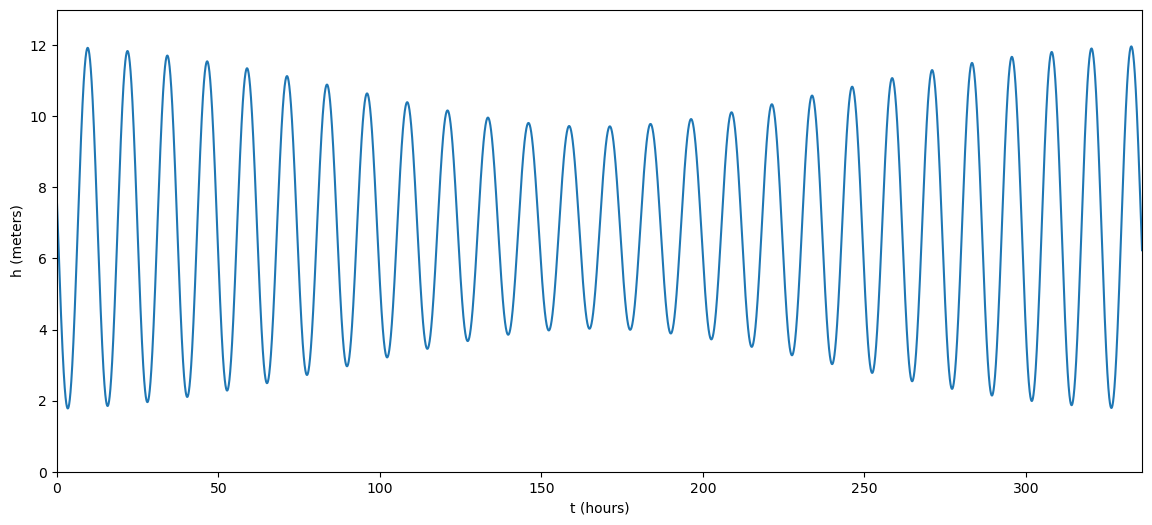

In [11]:

def plot_equation(results):
    plt.figure(figsize=(14,6))
    t_vals = np.linspace(0, 336, 20160)
    h_vals = results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads) + results[c]*np.cos(S2*t_vals*to_rads) + results[d]*np.sin(S2*t_vals*to_rads)
    #print(h_vals)
    p = plt.plot(t_vals, h_vals)
    plt.xlabel("t (hours)")
    plt.ylabel("h (meters)")
    ax = plt.gca()
    ax.set_xlim(0, 336)
    ax.set_ylim(0, 13)
    plt.savefig("Bristol_M2S2_2weeks.pdf", bbox_inches='tight')
    return h_vals
    
h_vals = plot_equation(results)

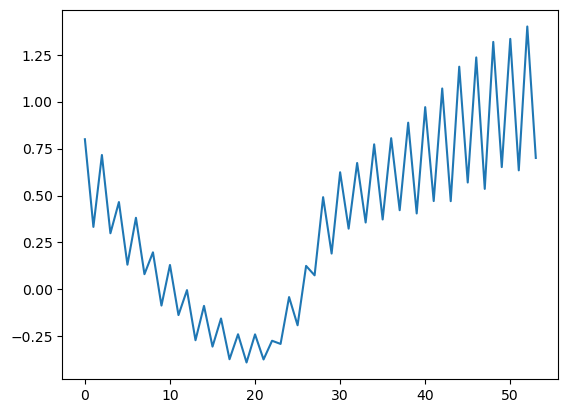

In [12]:
plt.plot(preds_df['Time Error'])

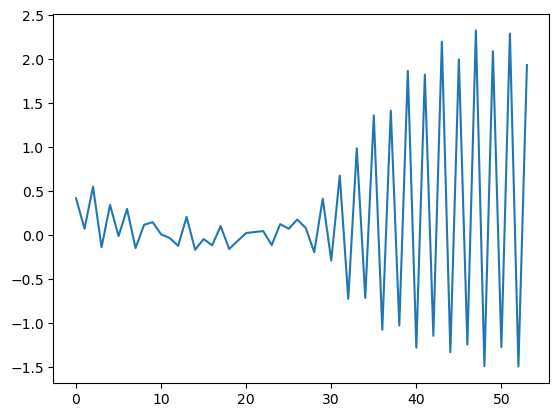

In [13]:
plt.plot(preds_df['Height Error'])

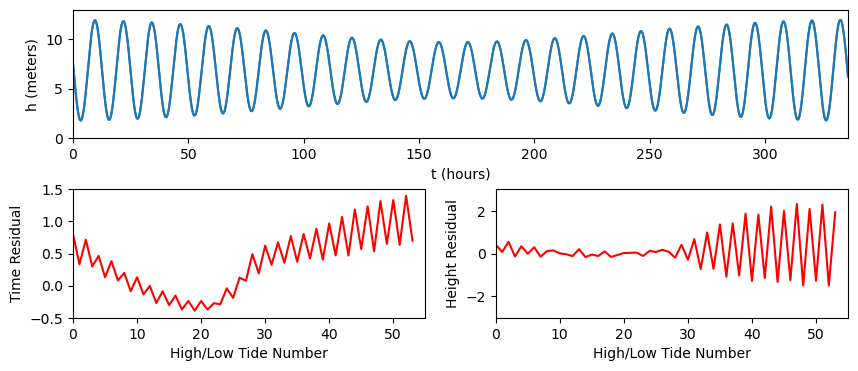

In [14]:
fig = plt.figure()
gs = fig.add_gridspec(2,2, hspace=0.4)

# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, :])


ax0 = fig.add_subplot(gs[0, :]) #= plt.subplot(2, 2, 1)
t_vals = np.linspace(0, 336, 20160)
h_vals = results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads) + results[c]*np.cos(S2*t_vals*to_rads) + results[d]*np.sin(S2*t_vals*to_rads)
#print(h_vals)
p = plt.plot(t_vals, h_vals)
plt.xlabel("t (hours)")
plt.ylabel("h (meters)")
ax0.set_xlim(0, 336)
ax0.set_ylim(0, 13)
plt.plot(t_vals, h_vals, 'tab:blue')
plt.xlabel("t (hours)")
plt.ylabel("h (meters)")

plt.gcf().set_size_inches((10, 4))
ax1 = fig.add_subplot(gs[1, 0])
plt.plot(preds_df["Time Error"], 'r')
plt.xlabel("High/Low Tide Number")
plt.ylabel("Time Residual")
#ax1.set_aspect('equal')
ax1.set_xlim(0, 55)
ax1.set_ylim(-0.5, 1.5)
ax2 = fig.add_subplot(gs[1, 1])
plt.plot(preds_df["Height Error"], 'r')
plt.xlabel("High/Low Tide Number")
plt.ylabel("Height Residual")
ax2.set_xlim(0, 55)
ax2.set_ylim(-3, 3)
#ax2.set_aspect('equal')
plt.savefig("BristolM2S2PlotAndErrors.pdf", bbox_inches='tight')

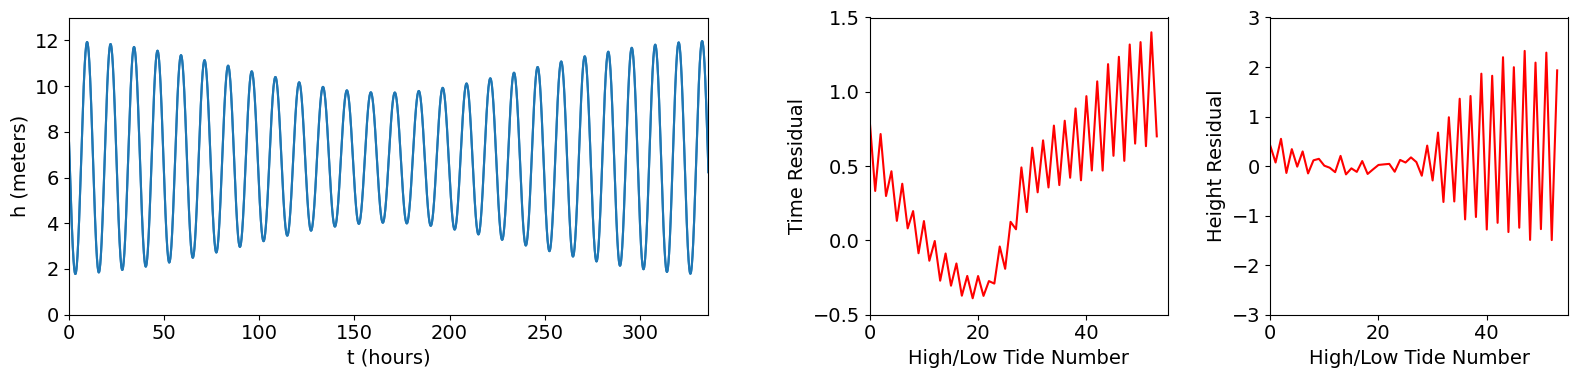

In [15]:
# fig = plt.figure()
# gs = fig.add_gridspec(2,2, hspace=0.4)

# ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[1, :])
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
ax0 = plt.subplot(1,2,1) #= plt.subplot(2, 2, 1)
t_vals = np.linspace(0, 336, 20160)
h_vals = results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads) + results[c]*np.cos(S2*t_vals*to_rads) + results[d]*np.sin(S2*t_vals*to_rads)
#print(h_vals)
p = plt.plot(t_vals, h_vals)
plt.xlabel("t (hours)")
plt.ylabel("h (meters)")
ax0.set_xlim(0, 336)
ax0.set_ylim(0, 13)
plt.plot(t_vals, h_vals, 'tab:blue')
plt.xlabel("t (hours)")
plt.ylabel("h (meters)")

plt.gcf().set_size_inches((16, 4))
ax1 = plt.subplot(1,4,3)
plt.plot(preds_df["Time Error"], 'r')
plt.xlabel("High/Low Tide Number")
plt.ylabel("Time Residual")
#ax1.set_aspect('equal')
ax1.set_xlim(0, 55)
ax1.set_ylim(-0.5, 1.5)
ax2 = plt.subplot(1,4,4)
plt.plot(preds_df["Height Error"], 'r')
plt.xlabel("High/Low Tide Number")
plt.ylabel("Height Residual")
ax2.set_xlim(0, 55)
ax2.set_ylim(-3, 3)
plt.tight_layout()
#ax2.set_aspect('equal')
plt.savefig("BristolM2S2PlotAndErrors_horiz.pdf", bbox_inches='tight')

In [16]:
sample_size = 1
a_tot = 0
b_tot = 0 
h0_tot = 0
count = 0
for i in range(0,sample_size,1):
    count += 1
    results = solve_bristol(sp = 0, inc = 5)
    sy.pprint(results)
    a_tot += results[a]
    b_tot += results[b]
    h0_tot += results[h0]
    
a_avg = a_tot/(count)
b_avg = b_tot/(count)
h0_avg = h0_tot/(count)
print(a_avg)
print(b_avg)
print(h0_avg)
print(count)

{a: 0.677412682226402, b: -3.92164374930563, c: -0.0226484176902362, d: -1.135
53991887915, h₀: 6.86844094951666}
0.677412682226402
-3.92164374930563
6.86844094951666
1


## Donaghadee

In [17]:
h0, a, b, c, d, e, f, g, i = sy.symbols("h0, a, b, c, d, e, f, g, i")


def lin_eq_OS2K1(h, t):
    return sy.Eq(h0 + a*sy.cos(O*t*to_rads) + b*sy.sin(O*t*to_rads) 
                 + c*sy.cos(S2*t*to_rads) + d*sy.sin(S2*t*to_rads)
                 + e*sy.cos(K1*t*to_rads) + f*sy.sin(K1*t*to_rads), h)

def lin_eq_OS2K1N2(h_t, t):
    return sy.Eq(h0 + a*sy.cos(O*t*to_rads) + b*sy.sin(O*t*to_rads) 
                 + c*sy.cos(S2*t*to_rads) + d*sy.sin(S2*t*to_rads)
                 + e*sy.cos(K1*t*to_rads) + f*sy.sin(K1*t*to_rads)
                 + g*sy.cos(N2*t*to_rads) + i*sy.sin(N2*t*to_rads), h_t)

def solve_system_OSK1(heights_times):
    eqs = []
    for h_t in heights_times:
        eqs.append(lin_eq_OS2K1(h_t[0], h_t[1]))
    print(eqs)
    return sy.solve([eqs[0], eqs[1], eqs[2], eqs[3], eqs[4], eqs[5], eqs[6]], (h0,a,b,c,d,e,f), dict=True)[0]

def solve_system_OS2K1N2(heights_times):
    eqs = []
    for h_t in heights_times:
        eqs.append(lin_eq_OS2K1N2(h_t[0], h_t[1]))
    print(eqs)
    return sy.solve([eqs[0], eqs[1], eqs[2], eqs[3], eqs[4], eqs[5], eqs[6], eqs[7], eqs[8]], (h0,a,b,c,d,e,f,g,i), dict=True)[0]

def solve_bristol_OSK1(sp, inc):
    vals = [[bristol_data["h"][sp], bristol_data['t'][sp]], 
            [bristol_data['h'][sp+inc], bristol_data['t'][sp+inc]], 
            [bristol_data['h'][sp+2*inc], bristol_data['t'][sp+2*inc]],
            [bristol_data['h'][sp+3*inc], bristol_data['t'][sp+3*inc]],
            [bristol_data['h'][sp+4*inc], bristol_data['t'][sp+4*inc]],
            [bristol_data['h'][sp+5*inc], bristol_data['t'][sp+5*inc]],
            [bristol_data['h'][sp+6*inc], bristol_data['t'][sp+6*inc]]]

    sol = solve_system_OSK1(vals)
    #sy.pprint(sol)
    return sol

def solve_donaghadee_OSK1(sp, inc):
    vals = [[donaghadee_data["h"][sp], donaghadee_data['t'][sp]], 
            [donaghadee_data['h'][sp+inc], donaghadee_data['t'][sp+inc]], 
            [donaghadee_data['h'][sp+2*inc], donaghadee_data['t'][sp+2*inc]],
            [donaghadee_data['h'][sp+3*inc], donaghadee_data['t'][sp+3*inc]],
            [donaghadee_data['h'][sp+4*inc], donaghadee_data['t'][sp+4*inc]],
            [donaghadee_data['h'][sp+5*inc], donaghadee_data['t'][sp+5*inc]],
            [donaghadee_data['h'][sp+6*inc], donaghadee_data['t'][sp+6*inc]]]

    sol = solve_system_OSK1(vals)
    #sy.pprint(sol)
    return sol

def solve_donaghadee_OS2K1N2(sp, inc):
    vals = [[donaghadee_data["h"][sp], donaghadee_data['t'][sp]], 
            [donaghadee_data['h'][sp+inc], donaghadee_data['t'][sp+inc]], 
            [donaghadee_data['h'][sp+2*inc], donaghadee_data['t'][sp+2*inc]],
            [donaghadee_data['h'][sp+3*inc], donaghadee_data['t'][sp+3*inc]],
            [donaghadee_data['h'][sp+4*inc], donaghadee_data['t'][sp+4*inc]],
            [donaghadee_data['h'][sp+5*inc], donaghadee_data['t'][sp+5*inc]],
            [donaghadee_data['h'][sp+6*inc], donaghadee_data['t'][sp+6*inc]],
            [donaghadee_data['h'][sp+7*inc], donaghadee_data['t'][sp+7*inc]],
            [donaghadee_data['h'][sp+8*inc], donaghadee_data['t'][sp+8*inc]]]

    sol = solve_system_OS2K1N2(vals)
    #sy.pprint(sol)
    return sol

In [18]:
def get_local_max_minima_OSK1(results, endpoint=336):
    t_vals = np.linspace(0, endpoint, 20160) # 1 point per minute for 2 weeks by default
    h_vals = (results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads) 
              + results[c]*np.cos(S2*t_vals*to_rads) + results[d]*np.sin(S2*t_vals*to_rads)
              + results[e]*np.cos(K1*t_vals*to_rads) + results[f]*np.sin(K1*t_vals*to_rads) )
    
    predictions = {'Time' : [], 'Height' : [], 'High_or_Low' : []}
    for h in range(1,len(h_vals)-1):
        if h_vals[h-1] < h_vals[h] and h_vals[h] > h_vals[h+1]:
            print("High tide, t = " + str(t_vals[h]) + ", h = " + str(h_vals[h]))
            predictions['Time'].append(t_vals[h])
            predictions['Height'].append(h_vals[h])
            predictions['High_or_Low'].append("high")
        elif h_vals[h-1] > h_vals[h] and h_vals[h] < h_vals[h+1]:
            print("Low tide, t = " + str(t_vals[h]) + ", h = " + str(h_vals[h]))
            predictions['Time'].append(t_vals[h])
            predictions['Height'].append(h_vals[h])
            predictions['High_or_Low'].append("low")
    return pd.DataFrame(data = predictions)


def get_local_max_minima_OS2K1N2(results, endpoint=336):
    t_vals = np.linspace(0, endpoint, 20160) # 1 point per minute for 2 weeks by default
    h_vals = (results[h0] + results[a]*np.cos(O*t_vals*to_rads) + results[b]*np.sin(O*t_vals*to_rads) 
              + results[c]*np.cos(S2*t_vals*to_rads) + results[d]*np.sin(S2*t_vals*to_rads)
              + results[e]*np.cos(K1*t_vals*to_rads) + results[f]*np.sin(K1*t_vals*to_rads)
              + results[g]*np.cos(N2*t_vals*to_rads) + results[i]*np.sin(N2*t_vals*to_rads))
    
    predictions = {'Time' : [], 'Height' : [], 'High_or_Low' : []}
    for h in range(1,len(h_vals)-1):
        if h_vals[h-1] < h_vals[h] and h_vals[h] > h_vals[h+1]:
            print("High tide, t = " + str(t_vals[h]) + ", h = " + str(h_vals[h]))
            predictions['Time'].append(t_vals[h])
            predictions['Height'].append(h_vals[h])
            predictions['High_or_Low'].append("high")
        elif h_vals[h-1] > h_vals[h] and h_vals[h] < h_vals[h+1]:
            print("Low tide, t = " + str(t_vals[h]) + ", h = " + str(h_vals[h]))
            predictions['Time'].append(t_vals[h])
            predictions['Height'].append(h_vals[h])
            predictions['High_or_Low'].append("low")
    return pd.DataFrame(data = predictions)

In [19]:
results = solve_donaghadee_OS2K1N2(sp = 1, inc = 1)
sy.pprint(results)

[Eq(-0.630585095813025*a - 0.776120117596805*b - 0.515038074910054*c - 0.857167300702112*d - 0.497385558598317*e + 0.867529599551416*f - 0.687469812577523*g + h0 - 0.726212955540332*i, 0.8), Eq(0.574208778040987*a + 0.818708909943379*b + 0.350207381259468*c + 0.936672189248398*d - 0.815754503854701*e - 0.578398296540344*f + 0.679926149466104*g + h0 + 0.733280595183179*i, 4.0), Eq(-0.664222226075172*a - 0.747535172676004*b - 0.358367949545301*c - 0.933580426497202*d + 0.578337462822429*e - 0.815797633666656*f - 0.795193020766996*g + h0 - 0.60635638012926*i, 0.7), Eq(0.596329758485246*a + 0.802739571184159*b + 0.165047605860679*c + 0.986285601537231*d + 0.750735758225793*e + 0.660602619826128*f + 0.778607080174906*g + h0 + 0.627511764592113*i, 3.4), Eq(-0.714488198127655*a - 0.699647493196608*b - 0.216439613938101*c - 0.976296007119934*d - 0.643965456332913*e + 0.765054567367546*f - 0.893675559689966*g + h0 - 0.44871371052468*i, 0.8), Eq(0.682016412036106*a + 0.731336867464916*b + 0.0610

In [20]:
dpreds_df = get_local_max_minima_OS2K1N2(results)

High tide, t = 4.900243067612481, h = 13.7701794702587
Low tide, t = 10.967210675132694, h = -12.0671918179716
High tide, t = 17.13418324321643, h = 16.6545549510121
Low tide, t = 23.35115829158192, h = -14.6857969419462
High tide, t = 29.501463366238404, h = 17.4963759890841
Low tide, t = 35.60176596061312, h = -15.7101798149916
High tide, t = 41.76873852869686, h = 20.3614403194949
Low tide, t = 47.985713577062356, h = -18.5815859337047
High tide, t = 54.16935363857334, h = 21.3869289353866
Low tide, t = 60.286323726375315, h = -19.3854377995443
High tide, t = 66.45329629445905, h = 23.9505399405262
Low tide, t = 72.67027134282455, h = -22.2544418190604
High tide, t = 78.87057889776278, h = 24.9783733729776
Low tide, t = 85.02088397241927, h = -22.6492329357726
High tide, t = 91.18785654050299, h = 26.9871756018063
Low tide, t = 97.40483158886849, h = -25.2782444141599
High tide, t = 103.62180663723399, h = 27.8703360231261
Low tide, t = 109.78877920531772, h = -25.1370753543828
High

In [21]:
results = solve_donaghadee_OSK1(sp = 0, inc = 1)
sy.pprint(results)

[Eq(0.47946265021196*a + 0.877562286707744*b + 0.446197813109809*c + 0.894934361602025*d + 0.849552879754692*e + 0.527503463970152*f + h0, 3.4), Eq(-0.630585095813025*a - 0.776120117596805*b - 0.515038074910054*c - 0.857167300702112*d - 0.497385558598317*e + 0.867529599551416*f + h0, 0.8), Eq(0.574208778040987*a + 0.818708909943379*b + 0.350207381259468*c + 0.936672189248398*d - 0.815754503854701*e - 0.578398296540344*f + h0, 4.0), Eq(-0.664222226075172*a - 0.747535172676004*b - 0.358367949545301*c - 0.933580426497202*d + 0.578337462822429*e - 0.815797633666656*f + h0, 0.7), Eq(0.596329758485246*a + 0.802739571184159*b + 0.165047605860679*c + 0.986285601537231*d + 0.750735758225793*e + 0.660602619826128*f + h0, 3.4), Eq(-0.714488198127655*a - 0.699647493196608*b - 0.216439613938101*c - 0.976296007119934*d - 0.643965456332913*e + 0.765054567367546*f + h0, 0.8), Eq(0.682016412036106*a + 0.731336867464916*b + 0.0610485395348574*c + 0.998134798421867*d - 0.708993890921115*e - 0.70521462168

In [22]:
dpreds_df = get_local_max_minima_OSK1(results)

Low tide, t = 6.000297633811201, h = -0.723432396543463
High tide, t = 12.133935215040427, h = 6.04517464541829
Low tide, t = 18.23423780941515, h = -1.29442718453451
High tide, t = 24.217867949799096, h = 6.33630738170111
Low tide, t = 30.268168063892055, h = -2.10847689652110
High tide, t = 36.401805645121286, h = 7.41314214702236
Low tide, t = 42.51877573292326, h = -2.63041879666026
High tide, t = 48.552408353588966, h = 7.59626894308958
Low tide, t = 54.60270846768193, h = -3.29705369692422
High tide, t = 60.73634604891115, h = 8.56941511296231
Low tide, t = 66.85331613671313, h = -3.74213872581307
High tide, t = 72.9036162508061, h = 8.61530359040648
Low tide, t = 78.97058385832631, h = -4.22642465412386
High tide, t = 85.08755394612828, h = 9.45278009414790
Low tide, t = 91.20452403393026, h = -4.57232744510671
High tide, t = 97.27149164145047, h = 9.34267205688391
Low tide, t = 103.33845924897068, h = -4.85034133087643
High tide, t = 109.45542933677265, h = 10.0194610924300
Low

In [23]:
results = solve_donaghadee(sp = 0, inc = 5)
sy.pprint(results)

{a: 2.4426536093072, b: -0.498008602049127, c: 0.602121021282481, d: 0.0374447
558426494, h₀: 2.36369671295705}


In [24]:
dpreds_df = get_local_max_minima(results)

Low tide, t = 5.883625179820427, h = -0.726326881835045
High tide, t = 12.050597747904161, h = 5.45925953311111
Low tide, t = 18.217570315987896, h = -0.731602586222674
High tide, t = 24.384542884071628, h = 5.45293292780756
Low tide, t = 30.551515452155364, h = -0.713715765320501
High tide, t = 36.7184880202391, h = 5.42359914799016
Low tide, t = 42.88546058832283, h = -0.673118591973433
High tide, t = 49.052433156406565, h = 5.37199107248483
Low tide, t = 55.2194057244903, h = -0.610819130675825
High tide, t = 61.403045786001286, h = 5.29941270047178
Low tide, t = 67.57001835408502, h = -0.528485176368921
High tide, t = 73.753658415596, h = 5.20788634785445
Low tide, t = 79.93729847710699, h = -0.428402545940049
High tide, t = 86.12093853861798, h = 5.10002967370135
Low tide, t = 92.30457860012898, h = -0.313646163461277
High tide, t = 98.48821866163996, h = 4.97930362586502
Low tide, t = 104.6885262165782, h = -0.188033341794824
High tide, t = 110.88883377151645, h = 4.8500076780442

In [25]:
dpreds_df['Forecasted Time'] = donaghadee_data['t']
dpreds_df['Forecasted Height'] = donaghadee_data['h']
dpreds_df['Time Error'] = dpreds_df['Time'] - dpreds_df['Forecasted Time']
dpreds_df['Height Error'] = dpreds_df['Height'] - dpreds_df['Forecasted Height']

In [32]:
dpreds_df.head(28)

,Time,Height,High_or_Low,Forecasted Time,Forecasted Height,Time Error,Height Error
0,5.883625,-0.726326881835045,low,2.116667,3.4,3.766959,-4.12632688183504
1,12.050598,5.45925953311111,high,7.966667,0.8,4.083931,4.65925953311111
2,18.217570,-0.731602586222674,low,14.316667,4.0,3.900904,-4.73160258622267
3,24.384543,5.45293292780756,high,20.300000,0.7,4.084543,4.75293292780756
4,30.551515,-0.713715765320501,low,26.683333,3.4,3.868182,-4.11371576532050
5,36.718488,5.42359914799016,high,32.583333,0.8,4.135155,4.62359914799016
6,42.885461,-0.673118591973433,low,38.883333,3.9,4.002127,-4.57311859197343
7,49.052433,5.37199107248483,high,44.916667,0.7,4.135766,4.67199107248483
8,55.219406,-0.610819130675825,low,51.283333,3.4,3.936072,-4.01081913067582
9,61.403046,5.29941270047178,high,57.250000,0.9,4.153046,4.39941270047178


In [27]:
#dpreds_df.head(28) # OSK1 sp = 5, inc = 3

In [28]:
#dpreds_df.head(28) # OSK1 sp = 5, inc = 1

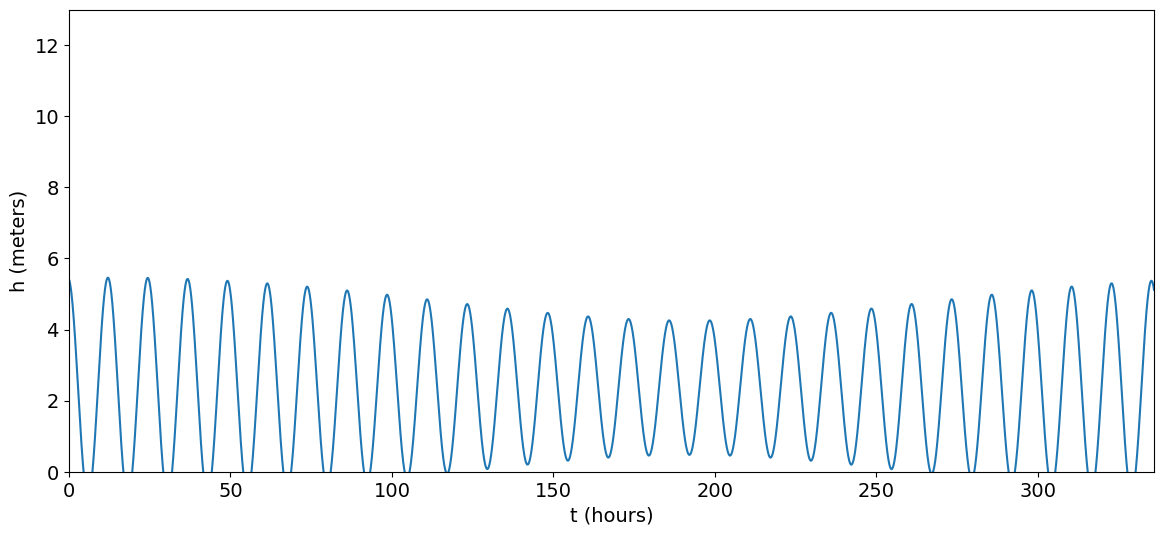

In [29]:
p = plot_equation(results)

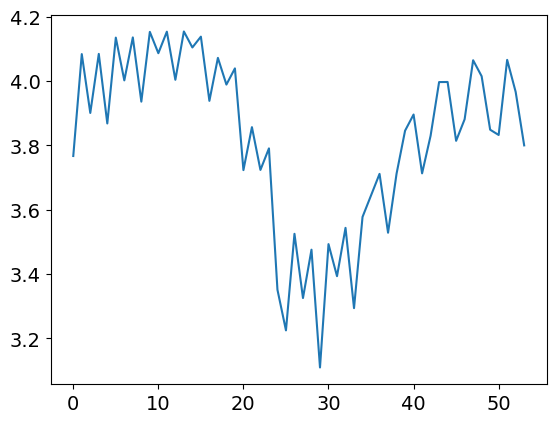

In [30]:
plt.plot(dpreds_df['Time Error'])

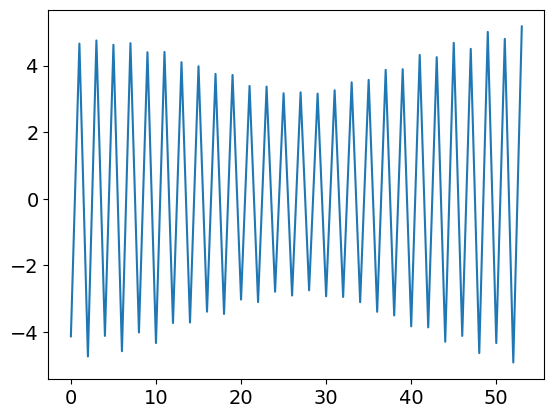

In [31]:
plt.plot(dpreds_df['Height Error'])